# Find Explanation for Extreme Outliers

<hr/>

#### Imports

In [1]:
import copy
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from ensemble_uncertainties.constants import (
    RANDOM_SEED,
    MEMORY_GROWTH,
    N_REPS,
    N_SPLITS
)
from ensemble_uncertainties.evaluators.evaluator_support import scale_and_filter
from ensemble_uncertainties.neural_estimators.neural_estimator import ShallowNeuralRegressor
from ensemble_uncertainties.utils.plotting import plot_r2

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage

from sklearn.metrics import mean_squared_error, r2_score

#### Constants

In [2]:
DATA_FOLDER = '../../../data/featurized/'
RESULT_FOLDER = '../../../data/results/kfold_ensembles/'
ALLOWED_RANGE_FACTOR = .5
PLOT_FOLDER = './plots/outlier_filter_examples/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

#### Functions

In [4]:
def load_results_file(name, algorithm, descriptor, n_repetitions=N_REPS, n_splits=N_SPLITS):
    """Loads results from disk for a given combination of ML settings."""
    path = f'{RESULT_FOLDER}{name}/{algorithm}/{descriptor}/single_predictions/test.csv'
    results = pd.read_csv(path, sep=';').set_index('id')
    single_tables = list()
    for i in range(n_repetitions):
        partial_results = results[[f'rep{i}_split{j}' for j in range(n_splits)]]
        single_tables.append(partial_results)
    return single_tables


def load_true(name):
    """Loads dependent variables of a given dataset."""
    path = f'{DATA_FOLDER}{name}/{name}_y.csv'
    y = pd.read_csv(path, sep=';').set_index('id')
    return y


def plot_r2_test(y, te_preds, title='', path='', show=False):
    """Plots observed vs. predicted scatter plot."""
    # Compute scores
    te_r2 = r2_score(y, te_preds)
    # Get corner values of the outputs/predictions
    smallest = min(min(y), min(te_preds.values))
    biggest = max(min(y), max(te_preds.values))
    # Plot
    plt.figure(figsize=(5, 5))
    plt.grid(zorder=1000)
    plt.plot(y, te_preds, 'o', zorder=100, markersize=4, label=None,
        color='C1', mfc='none', alpha=.7)
    plt.scatter([], [], label=f'Test,  $R^2$: {te_r2:.3f}',
        color='C1', facecolor='none')
    plt.plot([smallest-.2, biggest+.2], [smallest-.2, biggest+.2], zorder=100,
        color='k', label='$\hat{y}$ = $y$')
    plt.xlim(smallest-.2, biggest+.2)
    plt.ylim(smallest-.2, biggest+.2)
    plt.xlabel('$y$')
    plt.ylabel('$\hat{y}$')
    plt.legend()
    plt.title(title)
    if path:
        plt.savefig(f'{path}', bbox_inches='tight', pad_inches=0.01)
    if show:
        plt.show()
        
        
def clean_member(member_raw, y):
    """Removes predictions that are outside the allowed y-range"""
    member = copy.deepcopy(member_raw)
    for column in member.columns:
        # To the current column, those indeces
        # that are nan belong to training samples
        train_y = y.loc[member[~member[column].isnull()].index]
        train_y_range = train_y.max() - train_y.min()
        boundary = ALLOWED_RANGE_FACTOR * train_y_range
        allowed_min = (train_y.min() - boundary).values[0]
        allowed_max = (train_y.max() + boundary).values[0]
        exclusion = ((member[column] < allowed_min) | (member[column] > allowed_max))
        member.loc[exclusion] = np.nan
    return member


def reset_tf(seed=RANDOM_SEED):
    """Resets TensorFlow settings for determinism."""
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(seed)
    # Set growth ability of GPU memory (if available)
    gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
    if len(gpus) > 0:
        tf.config.experimental.set_memory_growth(gpus[0], MEMORY_GROWTH)

<hr/>

#### Load Data

In [5]:
tetrahymena_y = load_true('tetrahymena')
tetrahymena_smiles = pd.read_csv('../../../data/smiles/tetrahymena.csv', sep=';').set_index('id')
tetrahymena_rdkit = pd.read_csv('../../../data/featurized/tetrahymena/tetrahymena_rdkit.csv', sep=';').set_index('id')
tetrahymena_rdkit_shallow = load_results_file('tetrahymena', 'shallow', 'rdkit')

<hr/>

#### Plot

Plot member with extreme outlier, raw

Number of predictions in raw member: 1571


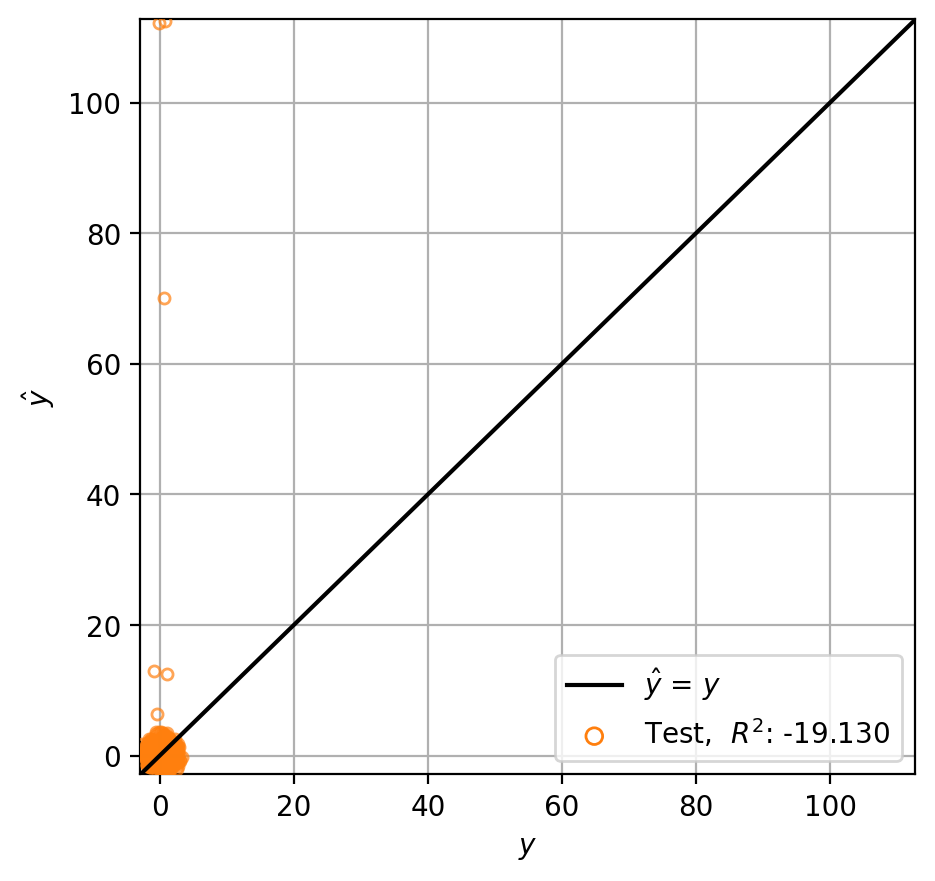

In [6]:
tetrahymena_member33 = tetrahymena_rdkit_shallow[33]
tetrahymena_member33_pred = tetrahymena_member33.mean(axis=1)
print(f'Number of predictions in raw member: {len(tetrahymena_member33_pred)}')

image_path = f'{PLOT_FOLDER}raw.pdf'
plot_r2_test(tetrahymena_y['y'], tetrahymena_member33_pred, path=image_path)

Filter

In [7]:
tetrahymena_member33_filtered = clean_member(tetrahymena_member33, tetrahymena_y)
tetrahymena_member33_filtered_pred = tetrahymena_member33_filtered.mean(axis=1).dropna()

Outliers are:

In [8]:
completed_indeces = list(tetrahymena_member33.index)
filtered_indeces = list(tetrahymena_member33_filtered_pred.index)

outlier_indeces = list()

for completed_i in completed_indeces:
    if completed_i not in filtered_indeces:
        outlier_indeces.append(completed_i)

tetrahymena_member33_outliers = tetrahymena_member33.loc[outlier_indeces]

print('The outliers and their predictions are:')
tetrahymena_member33_outliers.dropna(axis=1).rename(columns={'rep33_split1': 'predicted'})

The outliers and their predictions are:


,predicted
id,
24065-40-5,6.457742
75310,13.025634
67710,70.112404
75650,112.117070
75649,112.529330
67630,12.438656


Visualize outliers

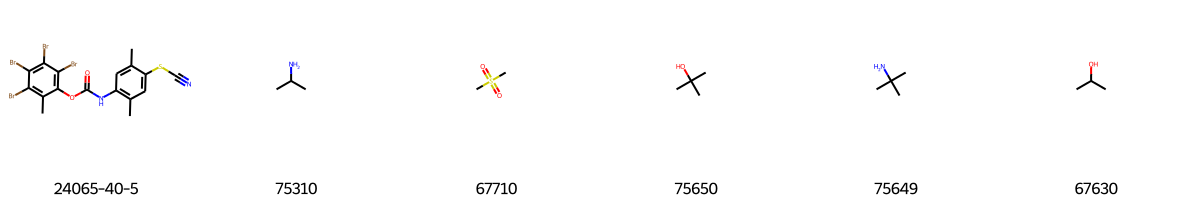

In [9]:
outliers_smiles = tetrahymena_smiles.loc[outlier_indeces]
outliers_molecules = [MolFromSmiles(smile) for smile in outliers_smiles['SMILES']]

MolsToGridImage(outliers_molecules, molsPerRow=6, legends=outlier_indeces)

Plot after applying outlier filter

Number of predictions after filtering out outliers: 1565


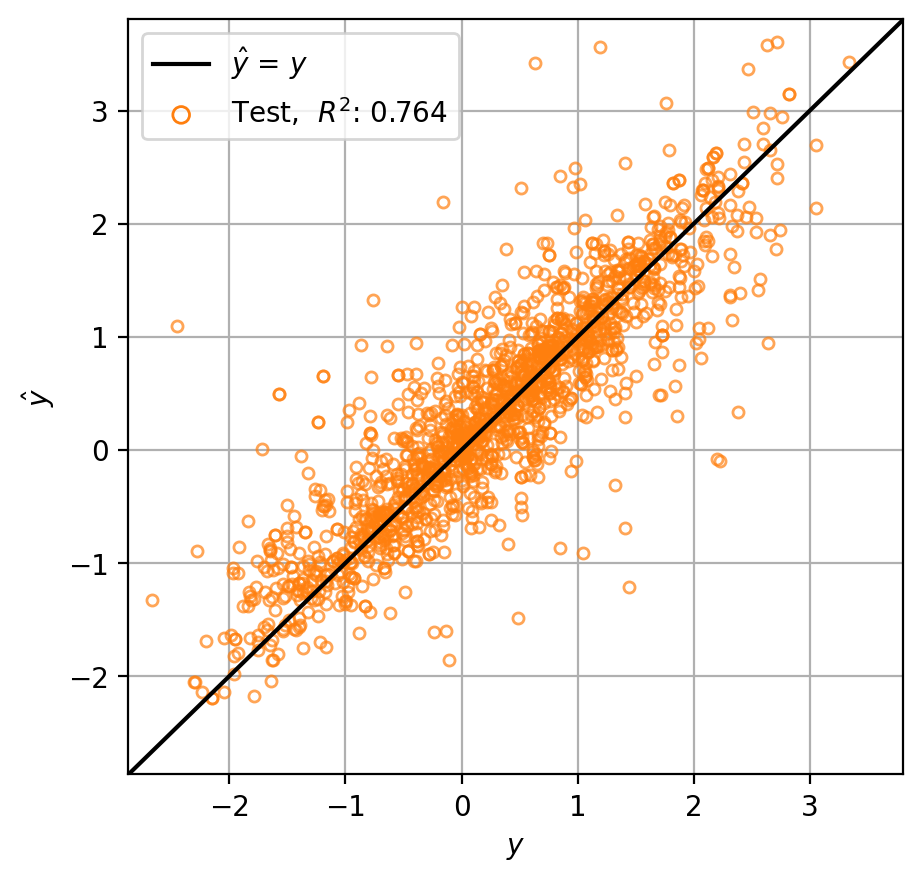

In [10]:
tetrahymena_member33_filtered_pred = tetrahymena_member33_filtered.mean(axis=1).dropna()
tetrahymena_filtered_y = tetrahymena_y.reindex(tetrahymena_member33_filtered_pred.index)
print(f'Number of predictions after filtering out outliers: {len(tetrahymena_member33_filtered_pred)}')

image_path = f'{PLOT_FOLDER}filtered.pdf'
plot_r2_test(tetrahymena_filtered_y['y'], tetrahymena_member33_filtered_pred, path=image_path)

Inspect descriptor distribution in outliers

In [11]:
train_index = tetrahymena_member33['rep33_split0'].dropna().index

X_train = tetrahymena_rdkit.loc[train_index]
y_train = tetrahymena_y.loc[train_index]

outliers_rdkit = tetrahymena_rdkit.loc[outlier_indeces]
outliers_y = tetrahymena_y.loc[outlier_indeces]

X_train_ready_for_ml, X_outliers_ready_for_ml, _, _ = scale_and_filter(X_train, outliers_rdkit)

Find variables in outlier set which are more than 3 standard deviations away from train mean:

In [12]:
# Standard deviation is 1.0 after standardization, so:
outlier_variables = (X_outliers_ready_for_ml.std() > 3)
print(f'{sum(outlier_variables)} variables are beyond 3 standard deviations.')

22 variables are beyond 3 standard deviations.


And which are those?

In [13]:
X_outliers_ready_for_ml.loc[:, outlier_variables].std()

MolWt                     4.401279
HeavyAtomMolWt            4.330484
ExactMolWt                4.395129
NumValenceElectrons       3.031052
Chi0                      3.160912
Chi0v                     4.215196
Chi1                      3.097944
Chi1v                     3.656462
Chi2v                     3.497883
Chi3v                     5.365914
Chi4v                     4.323441
Ipc                       3.005917
Kappa1                    3.284634
Kappa3                 1712.541751
LabuteASA                 3.892715
PEOE_VSA7                 4.435507
SMR_VSA10                 3.044864
HeavyAtomCount            3.096886
MolMR                     3.729580
fr_sulfide                4.690552
fr_sulfone                5.737379
fr_thiocyan              11.452811
dtype: float64

<hr/>

#### Show Sources of Outliers

Test prediction run for several seeds, with all variables

In [14]:
for i in range(10):
    reset_tf(seed=i)
    shallow_regressor = ShallowNeuralRegressor()
    shallow_regressor.fit(X_train_ready_for_ml, y_train)
    preds = shallow_regressor.predict(X_outliers_ready_for_ml)
    mse = mean_squared_error(outliers_y['y'].values, preds)
    print(f'MSE for seed={i}: {mse:.3f}')

MSE for seed=0: 307.654
MSE for seed=1: 505.939
MSE for seed=2: 2386.976
MSE for seed=3: 13465.979
MSE for seed=4: 30266.675
MSE for seed=5: 1023.218
MSE for seed=6: 11877.019
MSE for seed=7: 2567.464
MSE for seed=8: 175.339
MSE for seed=9: 12015.954


Remove extremely outlying variables

In [15]:
X_train_ready_for_ml_varfiltered = X_train_ready_for_ml.T[~outlier_variables].T
X_outliers_ready_for_ml_varfiltered = X_outliers_ready_for_ml.T[~outlier_variables].T

Test prediction run for several seeds, without outlier-responsible variables

In [16]:
for i in range(10):
    reset_tf(seed=i)
    shallow_regressor = ShallowNeuralRegressor()
    shallow_regressor.fit(X_train_ready_for_ml_varfiltered, y_train)
    preds = shallow_regressor.predict(X_outliers_ready_for_ml_varfiltered)
    mse = mean_squared_error(outliers_y['y'].values, preds)
    print(f'MSE for seed={i}: {mse:.3f}')

MSE for seed=0: 0.218
MSE for seed=1: 0.612
MSE for seed=2: 0.724
MSE for seed=3: 0.456
MSE for seed=4: 0.476
MSE for seed=5: 0.451
MSE for seed=6: 0.100
MSE for seed=7: 0.348
MSE for seed=8: 0.965
MSE for seed=9: 0.535


Test prediction run for several seeds, only without Kappa3

In [17]:
X_train_ready_for_ml_kappa3filtered = X_train_ready_for_ml.drop(columns=['Kappa3'])
X_outliers_ready_for_ml_kappa3filtered = X_outliers_ready_for_ml.drop(columns=['Kappa3'])

In [18]:
for i in range(10):
    reset_tf(seed=i)
    shallow_regressor = ShallowNeuralRegressor()
    shallow_regressor.fit(X_train_ready_for_ml_kappa3filtered, y_train)
    preds = shallow_regressor.predict(X_outliers_ready_for_ml_kappa3filtered)
    mse = mean_squared_error(outliers_y['y'].values, preds)
    print(f'MSE for seed={i}: {mse:.3f}')

MSE for seed=0: 0.623
MSE for seed=1: 1.452
MSE for seed=2: 3.191
MSE for seed=3: 0.506
MSE for seed=4: 0.435
MSE for seed=5: 1.016
MSE for seed=6: 0.814
MSE for seed=7: 3.458
MSE for seed=8: 0.039
MSE for seed=9: 0.854


Finally, show results of complete train/test evaluation of member 33 without Kappa3

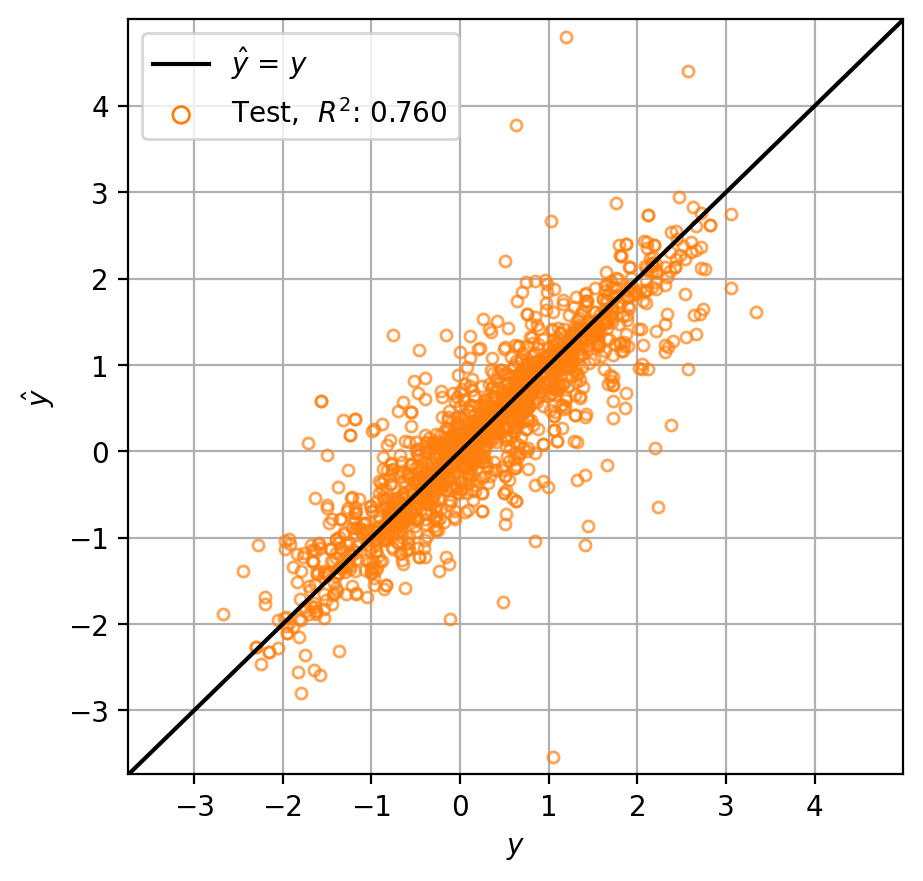

In [19]:
# Split

index_partition0 = tetrahymena_member33['rep33_split0'].dropna().index
index_partition1 = tetrahymena_member33['rep33_split1'].dropna().index

X_partition0 = tetrahymena_rdkit.loc[index_partition0]
X_partition1 = tetrahymena_rdkit.loc[index_partition1]

y_partition0 = tetrahymena_y.loc[index_partition0]
y_partition1 = tetrahymena_y.loc[index_partition1]

# Preprocess

X_partition0_kappa3filtered = X_partition0.drop(columns=['Kappa3'])
X_partition1_kappa3filtered = X_partition1.drop(columns=['Kappa3'])

X_train_partition0, X_test_partition0, _, _ = scale_and_filter(X_partition0_kappa3filtered, X_partition1_kappa3filtered)
X_train_partition1, X_test_partition1, _, _ = scale_and_filter(X_partition1_kappa3filtered, X_partition0_kappa3filtered)

# Fit, obtain predictions

reset_tf(seed=RANDOM_SEED)

shallow_regressor0 = ShallowNeuralRegressor()
shallow_regressor0.fit(X_train_partition0, y_partition0)
preds_partition0 = shallow_regressor0.predict(X_test_partition0)
preds_partition0_df = pd.DataFrame(preds_partition0, index=X_train_partition1.index, columns=['pred'])

shallow_regressor1 = ShallowNeuralRegressor()
shallow_regressor1.fit(X_train_partition1, y_partition1)
preds_partition1 = shallow_regressor1.predict(X_test_partition1)
preds_partition1_df = pd.DataFrame(preds_partition1, index=X_train_partition0.index, columns=['pred'])

# Concatenate

preds = pd.concat([preds_partition0_df, preds_partition1_df], axis=0).reindex(tetrahymena_y.index)

# Plot

image_path = f'{PLOT_FOLDER}kappa3_removed_beforehand.pdf'
plot_r2_test(tetrahymena_y['y'], preds['pred'], path=image_path)

Show Kappa3 values of outliers compared to average Kappa3 in training

In [20]:
X_train['Kappa3'].mean(), X_train['Kappa3'].std()

(3.1200449421713117, 2.5516625317129207)

In [21]:
outliers_rdkit['Kappa3']

id
24065-40-5       4.652138
75310         1128.960000
67710         6007.950000
75650         9507.960000
75649         9507.960000
67630         1128.960000
Name: Kappa3, dtype: float64